# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

   total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0       108.0  2019-03-07T00:00:00      3   
1             7   3350000.0        40.4  2018-12-04T00:00:00      1   
2            10   5196000.0        56.0  2015-08-20T00:00:00      2   
3             0  64900000.0       159.0  2015-07-24T00:00:00      3   
4             2  10000000.0       100.0  2018-06-19T00:00:00      2   

   ceiling_height  floors_total  living_area  floor is_apartment  ...  \
0            2.70          16.0         51.0      8          NaN  ...   
1             NaN          11.0         18.6      1          NaN  ...   
2             NaN           5.0         34.3      4          NaN  ...   
3             NaN          14.0          NaN      9          NaN  ...   
4            3.03          14.0         32.0     13          NaN  ...   

   kitchen_area  balcony    locality_name  airports_nearest  \
0          25.0      NaN  Санкт-Петербург           18863.0   
1       

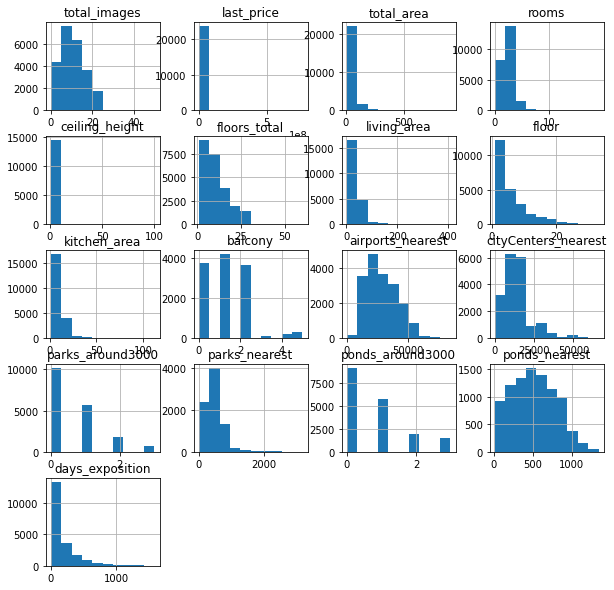

In [1]:
import pandas as pd
data = pd.read_csv('/datasets/real_estate_data.csv', '\t')
data.hist(figsize = (10, 10))
print(data.head())
print(data.info())
print(data.isna().sum())

Сохраним данные в переменную data, чтобы понять с какими данными мы работает, посмотрим первые 5 строк методом head и общую информацию методом info, и по числовым построили гистограммы.

### Предобработка данных

In [2]:
for i in data:
    data.loc[(data['balcony'].isna()), 'balcony'] = 0
    #data.loc[(data['living_area'].isna()) & (data['kitchen_area'].isna()), ('living_area' & 'kitchen_area')] = 0
    
    
data_wt_liv_kitc_area = data.query('living_area.isna() == False and kitchen_area.isna() == False')


Так как не имеет смысла для дальнейшего анализа квартир, в который нет данных по площади жилой и кухонной, удалим и сохраним в новый датафрейм. Также пропуски по балконам заполним 0, очевидно, что многие не ставят число, когда чего-то нет.

In [3]:
for i in data['ceiling_height']:
    if i > 20:
        data.loc[data['ceiling_height'] == i, 'ceiling_height'] = data.loc[data['ceiling_height'] == i, 'ceiling_height']/10
    data.loc[(data['ceiling_height'] == i) & (data['ceiling_height'].isna() == True), 'ceiling_height'] = data['ceiling_height'].median() 
    
data = data.query('2 <= ceiling_height <= 5')


В данных по полоткам были пропуски - логичнее всего заменить их медианным значением 2.65, те значение, которые были аномальны и не поддавались логике ошибки, например 23 м - явно ошибка, имели ввиду 2.3 м, такие значение мы превратили в правильные. А вот значения по типу 8м, 10 м, очень странные, слишком уж большие значение. Также и со значениями меньше 2м. Поэтому в финальную таблицу, с которой мы будем работать дальше, попадут те значения, где высота потолков лежит в пределах от 2 до 5 метров.

In [4]:
data = data.query('floors_total.isna() == False')


Так как пропуски в этажности дома сложно заполнить чем-то весомым, что не влияло бы на дальнейшие расчёты, проще удалить эти строчки, тем более их всего 9, а данных 14 тысяч, на исследование не повлияет.

In [5]:
data = data.reset_index(drop=True)
for i in data:
    data.loc[data['living_area'].isna(), 'living_area'] = data['living_area'].median()
    data.loc[data['kitchen_area'].isna(), 'kitchen_area'] = data['kitchen_area'].median()

Заменим пропуски в квадратуре жилой площади и кухонной медианными значениями по этой категории. На медиану не повлияют выбросы, что хорошо для нас.

In [6]:

for i in data:
    data.loc[data['is_apartment'].isna(), 'is_apartment'] = False
data = data.query('locality_name.isna() == False')

def replace_name(location_list, wrongs):
    for i in wrongs:
        location_list = location_list.str.replace(i, '')
    return location_list

locates = ['посёлок ', 'поселок ', 'деревня ', 'городского типа ', 'коттеджный ', 'село ', 'городской ', 'садоводческое некоммерческое товарищество ', 'садовое товарищество ', 'имени ', 'при железнодорожной станции ', 'станции ']  
data['locality_name_new'] = replace_name(data['locality_name'], locates)

Пропуски в названии локации нельзя заполнить тем, чтобы не повлияло на исследование. Но их всего 14, так что если их просто удалить, это не повлияет на наши исследования. С оcтальными дубликатами боремся так - убираем наименование объекта, оставляя только название и добавим их в новый столбец.


In [7]:
print(data.isna().sum())

total_images               0
last_price                 0
total_area                 0
first_day_exposition       0
rooms                      0
ceiling_height             0
floors_total               0
living_area                0
floor                      0
is_apartment               0
studio                     0
open_plan                  0
kitchen_area               0
balcony                    0
locality_name              0
airports_nearest        2959
cityCenters_nearest     2939
parks_around3000        2938
parks_nearest           9189
ponds_around3000        2938
ponds_nearest           8758
days_exposition         2447
locality_name_new          0
dtype: int64


In [8]:
for i in data:
    data.loc[data['parks_around3000'].isna(), 'parks_around3000'] = 0

for i in data:
    data.loc[data['ponds_around3000'].isna(), 'ponds_around3000'] = 0
for i in data:
    data.loc[data['days_exposition'].isna(), 'days_exposition'] = 0
    
for i in data:
    data.loc[data['cityCenters_nearest'].isna(), 'cityCenters_nearest'] = 0

data['floors_total'] = data['floors_total'].astype(int)
data['balcony'] = data['balcony'].astype(int)
data['last_price'] = data['last_price'].astype(int) #перевёл цену в целочисленный тип
data['days_exposition'] = data['days_exposition'].astype(int)
data['parks_around3000'] = data['parks_around3000'].astype(int)
data['ponds_around3000'] = data['ponds_around3000'].astype(int)
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%d %H:%M')
data['data_now'] = data['first_day_exposition'][1977] 
data['data_now'] = data['data_now'][0]
for i in data:
    data.loc[data['days_exposition'].isna(), 'days_exposition'] = (data['data_now'] - data['first_day_exposition']).dt.days
print(data['data_now'].head())

0   2019-05-03
1   2019-05-03
2   2019-05-03
3   2019-05-03
4   2019-05-03
Name: data_now, dtype: datetime64[ns]


In [9]:
print(data.duplicated().sum())

0


Поменяли тип на целочисленный, там, где это возможно. Также заполнили пропуски по по количеству ближайших парков и прудов значением 0, так как скорее всего пр  их отсутвие многие не указывают. Пропуски по количеству дней экспозиции - добавили в таблицу новый столбик с датой, на которую взяли данные(вычислили это сортировкой столибка по датам, приняв самую большую дату за последнюю), далее заполнили пропуски разницей между сегодняшней датой и датой выкладывания

### Посчитайте и добавьте в таблицу новые столбцы

In [10]:
data['price_one_square'] = data['last_price']/data['total_area']

Считаем цену за квадратный метр простым делением цены на общую площадь


In [11]:
data['weekday'] = data['first_day_exposition'].dt.weekday 

Определяем день недели публикации

In [12]:
data['month'] = data['first_day_exposition'].dt.month
data['year'] = data['first_day_exposition'].dt.year

Определили месяц и год публикации

In [13]:
def type_floor(floor):
    if floor['floor'] == 1:
        return 'Первый'
    if floor['floor'] == floor['floors_total']:
        return 'Последний'
    else:
        return 'Другой'
    
data['type_floor'] = data.apply(type_floor, axis=1)

Заполнили тип этажа, через функцию, которая сравнивает этаж со значением 1 или со значением в колонке floors_total

In [14]:
data['cityCenters_nearest_km'] = round(data['cityCenters_nearest']/1000)

Создали новый столбец, где храним расстояние до ближайшего города в километрах

### Проведите исследовательский анализ данных

<AxesSubplot:>

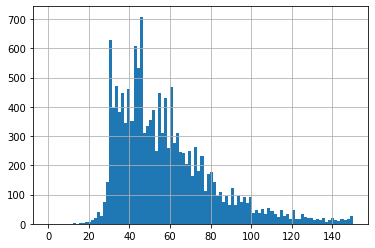

In [15]:
data['total_area'].hist(bins=100, range=(0,150))


Гистограмма распределения общей площади

<AxesSubplot:>

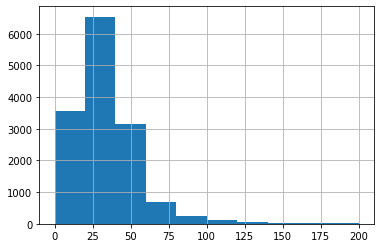

In [16]:
data['living_area'].hist(range=(0,200))

Гистограмма распределения общей площади жилой

<AxesSubplot:>

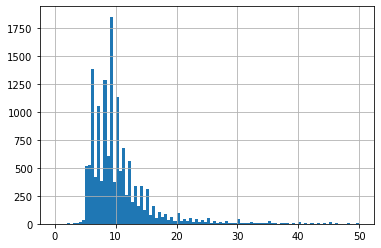

In [17]:
data['kitchen_area'].hist(bins=100, range=(0,50))

Гистограмма распределения площади кухни

<AxesSubplot:>

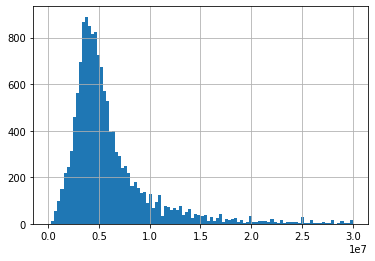

In [18]:
data['last_price'].hist(bins=100, range=(0, 30000000))


Гистограмма распределения по цене 

<AxesSubplot:>

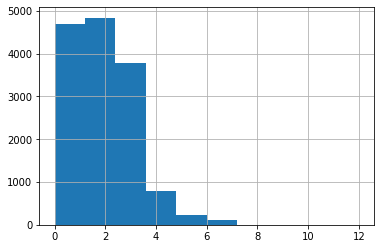

In [19]:
data['rooms'].hist(range=(0,12))

<AxesSubplot:>

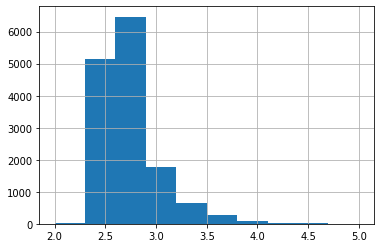

In [20]:
data['ceiling_height'].hist(range=(2,5))

<AxesSubplot:>

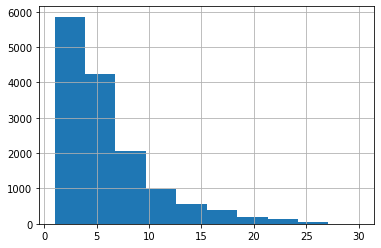

In [21]:
data['floor'].hist(range=(1,30))

<AxesSubplot:>

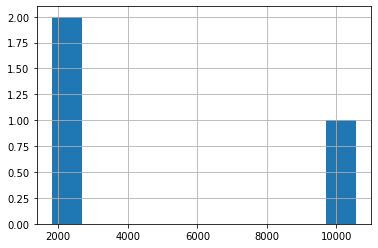

In [22]:

data['type_floor'].value_counts().hist()

<AxesSubplot:>

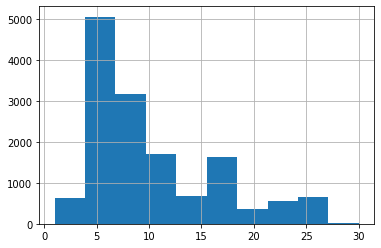

In [23]:
data['floors_total'].hist(range=(1,30))

<AxesSubplot:>

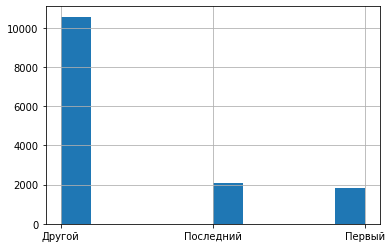

In [24]:
data['type_floor'].hist()

Зависимость цены от типа этажа

<AxesSubplot:>

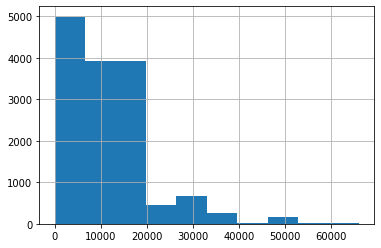

In [25]:
data['cityCenters_nearest'].hist()

<AxesSubplot:>

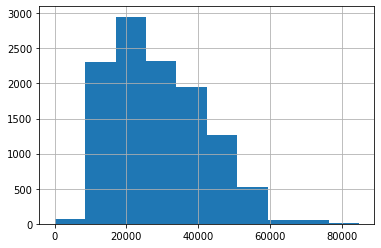

In [26]:
data['airports_nearest'].hist()

<AxesSubplot:>

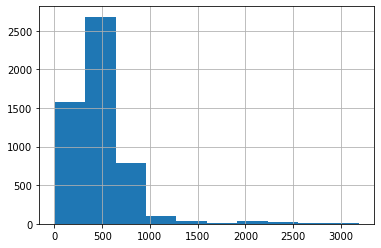

In [27]:
data['parks_nearest'].hist()

<AxesSubplot:>

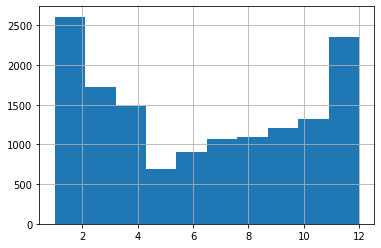

In [28]:
data['month'].hist()

<AxesSubplot:>

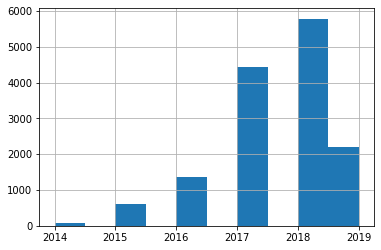

In [29]:
data['year'].hist()

Наблюдения по графикам: наиболее часто встречаемые предложения с общей площадью от 25 до 75, с жилой от 30 до 40, c площадью кухни от 5 до 10 метров, в ценовом диапазоне от 250 тыс до 750 тыс, с 1-2 комнатами, высотой потолоков 2.5-2.75 метров, на этажах ниже 5. Также преимущественно представлены объявления опубликованные в 2018 году, в январе или декабре, с растооянием до центра города в пределах 10000 метров, до аэоропорта - 20000 метров, до ближайшего парка - 500 метров.

158.01424324137454
72.0


count    14463.000000
mean       158.014243
std        220.147054
min          0.000000
25%         16.500000
50%         72.000000
75%        201.500000
max       1580.000000
Name: days_exposition, dtype: float64

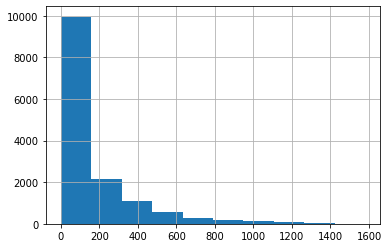

In [30]:
data['days_exposition'].hist()
print(data['days_exposition'].mean())
print(data['days_exposition'].median())
data['days_exposition'].describe()

в среднем продажа занимает 72 дня, быстрыми можно считать значения, меньше 25% квартиля, то есть менябше 16 дней, необычно долгими - значения, больше 202 дней.

0.7118739376178385


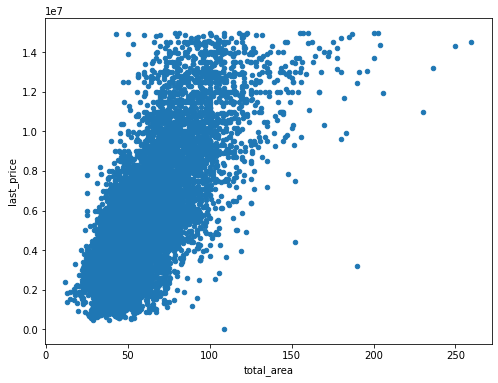

In [44]:
data.query('last_price < 15000000').plot(x='total_area', y='last_price', kind='scatter',  figsize=(8, 6))
print(data['last_price'].corr(data['total_area']))

По графику видно, что существует зависимость цены от общей квадратуры, причём зависимость прямая, коэффицент Пирсона только подтверждает это 0.71 - связь есть и достаточно неплохая.

0.5880167880577793


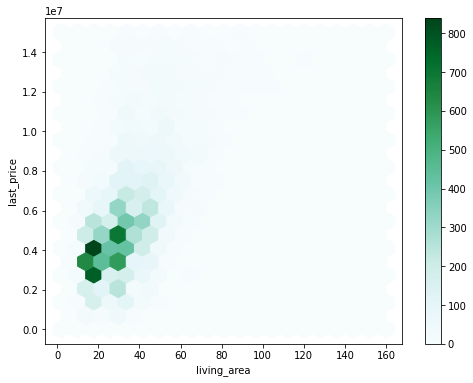

In [32]:
data.query('last_price < 15000000').plot(x='living_area', y='last_price', kind='hexbin', gridsize=20, figsize=(8, 6), sharex=False)
print(data['last_price'].corr(data['living_area']))

Здесь связь уже не такая большая, но есть. Всё-таки покупателям недвижимости важна не только жилая площадь.

0.5101477799179588


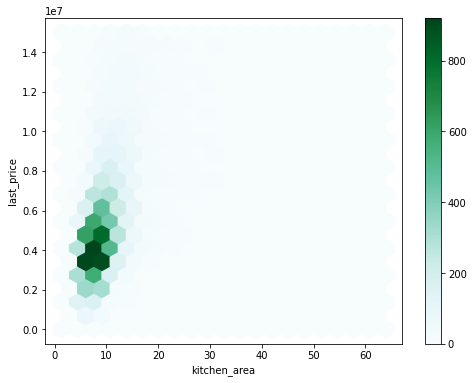

In [33]:
data.query('last_price < 15000000').plot(x='kitchen_area', y='last_price', kind='hexbin', gridsize=20, figsize=(8, 6), sharex=False)
print(data['last_price'].corr(data['kitchen_area']))

Пощадь кухни тоже не особо важна, видимо для кулинарных шедевров не так много надо)

0.40113628359619286


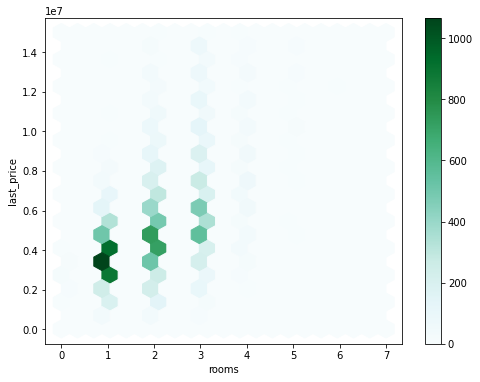

In [34]:
data.query('last_price < 15000000').plot(x='rooms', y='last_price', kind='hexbin', gridsize=20, figsize=(8, 6), sharex=False)
print(data['last_price'].corr(data['rooms']))

Странно, но количество комнат не ключевой фактор цены квартиры, всё-таки 100 квадратов в однушке лучше, чем 50 в двушке)

<AxesSubplot:xlabel='type_floor'>

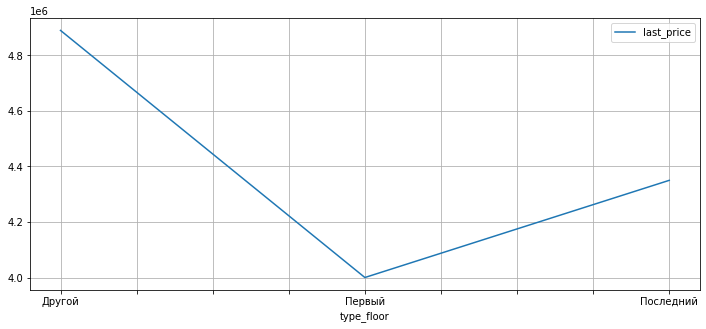

In [35]:
data.query('last_price < 15000000').pivot_table(index='type_floor', values='last_price', aggfunc='median').plot(grid=True, figsize=(12, 5))


0.0034554911496788637


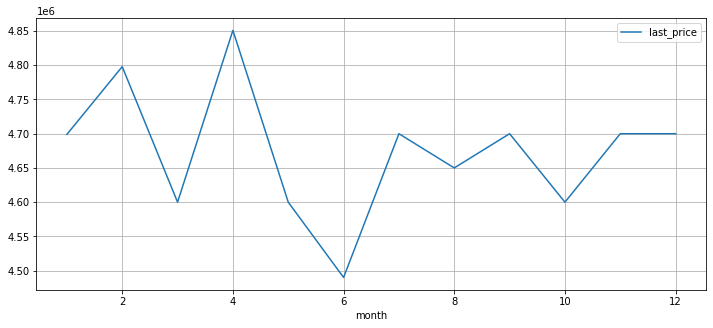

In [36]:
data.query('last_price < 15000000').pivot_table(index='month', values='last_price', aggfunc='median').plot(grid=True, figsize=(12, 5))
print(data['last_price'].corr(data['month']))

Как можно заметить, народ просыпается после зимней спячки и охотно покупает недвижимость, пока на дачу не уехали, конечно.) А так, зависимости цены от этого никакой

<AxesSubplot:xlabel='year'>

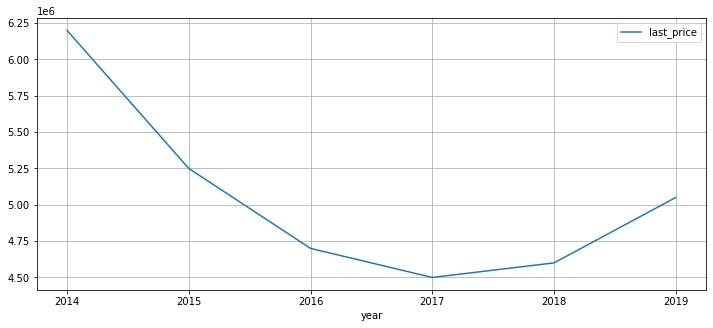

In [37]:
data.query('last_price < 15000000').pivot_table(index='year', values='last_price', aggfunc='median').plot(grid=True, figsize=(12, 5))

2014 год тряхнул сильно, что только после 2017 спрос на недвижимость стал расти, а не падать, оно и логично

<AxesSubplot:xlabel='weekday'>

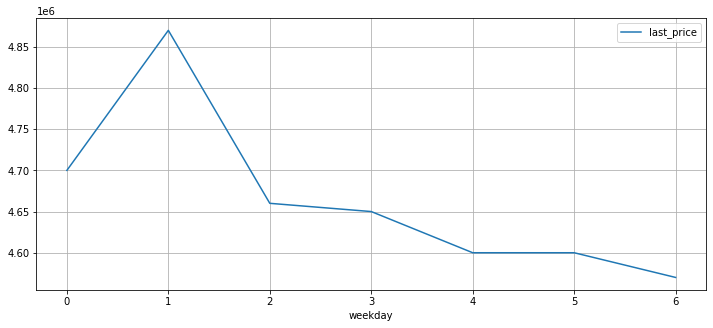

In [38]:
data.query('last_price < 15000000').pivot_table(index='weekday', values='last_price', aggfunc='median').plot(grid=True, figsize=(12, 5))

In [39]:
print(data.pivot_table(index='locality_name_new', values='price_one_square', aggfunc=['count', 'median']).sort_values(by=[( 'count', 'price_one_square')], ascending=False).head(10))

                             count           median
                  price_one_square price_one_square
locality_name_new                                  
Санкт-Петербург              10081    105699.185831
Всеволожск                     272     65737.874097
Пушкин                         234    100000.000000
Мурино                         228     86432.673131
Шушары                         216     77661.027977
Колпино                        203     74725.274725
Кудрово                        195     96540.969663
Гатчина                        149     68604.651163
Петергоф                       145     82142.857143
Парголово                      137     91040.462428


<AxesSubplot:xlabel='cityCenters_nearest_km'>

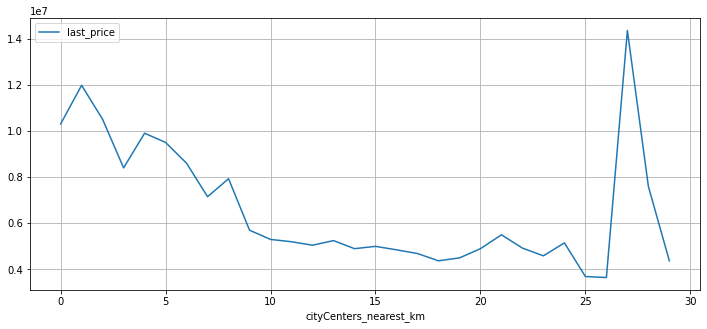

In [40]:
data.query('locality_name_new == "Санкт-Петербург"').pivot_table(index='cityCenters_nearest_km', values='last_price', aggfunc='median').plot(grid=True, figsize=(12, 5))


Также виден всплеск по цене в диапазоне от 25 до 30 км, скорее всего это связано с тем, что сюда попадают объявления в категории коттеджей и домов, а они всегда были в цене

Вывод: самые дрогой квадратный метр в Санкт-Петербурге, Пушкине и Кудрово. Также, чем ближе к центру Санкт-Петербурга, тем дороже квартиры, самые дорогие в диапазоне 2-3 км до центра.
Также, логично, что чем больше по площади квартира, тем она, как правило дороже. По этажности самые дорогие находятся не на первом и не на последнем. На первом - самые дешёвые. Самые дорогие объявление выложены в 2014 году. Также в апреле и во вторник публикуются, как правило самые дорогостоящие квартиры.

### Общий вывод

Общий вывод: проведя исследование, можно сказать, что самая дорогая недвижимость находится в Санкт-Петербурге, как правило в районе 2-3 км от центра, с площадью около 200 квадратных метров. 
Наиболее часто встречаемые предложения с общей площадью от 25 до 75, с жилой от 30 до 40, c площадью кухни от 5 до 10 метров, в ценовом диапазоне от 250 тыс до 750 тыс, с 1-2 комнатами, высотой потолоков 2.5-2.75 метров, на этажах ниже 5. 
Также мы можем сказать, что в среднем на продажу квартиры тратится 72 дня, если это значение превышает 158 дней - то это можно считать долгим объявлением.

В ходе работы мною было осуществлено следующее:
Избавились от пробелах в данных
Убрали строчки данных, где значения были аномальными
Поработали с дубликатами, превратив их в единое целое
Рассчитали цену за квадратный метр
Поставили каждому объекту тип, в зависимости от этажа
Изучили, что в основном выбирают потребители
Посмотрели, что оказывает и как оказывает влияние на цену объекта